# Classification of Sugarcane Diseases based on Images

## Initial Setup

Examining the train data shows that there are six (6) classes in total:

In [1]:
classes = [
    "Banded_Chlorosis",
    "Brown_Rust",
    "Brown_Spot",
    "Viral",
    "Yellow_Leaf",
    "Healthy",
]

## Data Loading and Preprocessing



In [2]:
import keras
import tensorflow as tf
from pathlib import Path
from pprint import pprint
import os


# To make random outcomes reproducible
SEED = 1738
BATCH_SIZE = 128
IMAGE_SIZE = 128
TRAIN_DIRECTORY = Path("./train")


train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    color_mode="rgb",
    batch_size=None,  # type: ignore
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
)

class_count = {}

for image, label in train_ds:
    key = str(label.numpy())
    if class_count.get(key) == None:
        class_count[key] = 1
    else:
        class_count[key] += 1

minimum_class = min(class_count, key=class_count.get)  # type: ignore
minimum_class_count = min(class_count.values())

# pprint(class_count)
# print(f"MINIMUM: {minimum_class}, {minimum_class_count} ")

2025-05-19 22:05:25.187794: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 22:05:25.336193: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 22:05:25.475961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747663525.580385    6300 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747663525.604426    6300 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747663525.793147    6300 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Found 4314 files belonging to 6 classes.
Using 3452 files for training.
Using 862 files for validation.


2025-05-19 22:05:29.278007: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-19 22:05:30.825616: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
class_datasets = []
for class_idx in range(len(classes)):
    class_ds: tf.data.Dataset = train_ds.filter(lambda img, label: tf.argmax(label) == class_idx)
    class_datasets.append(
        class_ds.take(minimum_class_count).shuffle(buffer_size=minimum_class_count, seed=SEED)
    )


# Recombine the class datasets using sample_from_datasets to interweave them
train_ds_balanced = tf.data.Dataset.sample_from_datasets(class_datasets, seed=SEED)

class_count = {}
for image, label in train_ds_balanced:  # type: ignore
    key = str(label.numpy())
    if class_count.get(key) == None:
        class_count[key] = 1
    else:
        class_count[key] += 1

pprint(class_count)

# Batch the data set for model compatibility
# Prefetch to optimize


def config_performance(dataset):
    dataset = dataset.cache()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset.prefetch(tf.data.AUTOTUNE)


train_ds_optimized = config_performance(train_ds_balanced)
validation_ds_optimized = config_performance(validation_ds)

{'[0. 0. 0. 0. 0. 1.]': 228,
 '[0. 0. 0. 0. 1. 0.]': 228,
 '[0. 0. 0. 1. 0. 0.]': 228,
 '[0. 0. 1. 0. 0. 0.]': 228,
 '[0. 1. 0. 0. 0. 0.]': 228,
 '[1. 0. 0. 0. 0. 0.]': 228}


2025-05-19 22:05:35.952331: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Method 1: Convolution Neural Network (CNN)

The first method for solving this classification problem is through the use of CNN.

We will be using the Keras and TensorFlow libraries.

First, let us setup the environment and model.

In [4]:
import keras
from keras.api.applications.inception_v3 import InceptionV3

EPOCHS = 60
DROPOUT_RATE = 0.2

pre_trained_model = InceptionV3(
    weights="imagenet",
    classes=len(classes),
    include_top=False,  # the fully connected layer at the end
)

for layer in pre_trained_model.layers:
    layer.trainable = False

transfer_model = keras.models.Sequential(
    [
        # preprocessing layers
        keras.layers.Rescaling(1.0 / 255),
        # data augmentation layers
        keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
        keras.layers.RandomRotation(0.05, seed=SEED),
        pre_trained_model,
        # fully connected
        # keras.layers.Flatten(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(len(classes), activation="softmax"),
    ]
)

# transfer_model.summary()

transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = transfer_model.fit(
    train_ds_optimized, epochs=EPOCHS, validation_data=validation_ds_optimized
)

Epoch 1/60
     11/Unknown 14s 518ms/step - accuracy: 0.2051 - loss: 5.0162

/home/ubuntu/CS180-Project/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2098 - loss: 4.9179 - val_accuracy: 0.2169 - val_loss: 1.7525
Epoch 2/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.3449 - loss: 1.6716

2025-05-16 18:23:43.711438: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 838ms/step - accuracy: 0.3475 - loss: 1.6621 - val_accuracy: 0.4420 - val_loss: 1.4815
Epoch 3/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 949ms/step - accuracy: 0.4299 - loss: 1.4232 - val_accuracy: 0.4780 - val_loss: 1.3175
Epoch 4/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 913ms/step - accuracy: 0.5014 - loss: 1.2516 - val_accuracy: 0.4907 - val_loss: 1.2530
Epoch 5/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5672 - loss: 1.1308 - val_accuracy: 0.5394 - val_loss: 1.1600
Epoch 6/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.6269 - loss: 0.9952

2025-05-16 18:24:27.960839: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 906ms/step - accuracy: 0.6276 - loss: 0.9942 - val_accuracy: 0.5557 - val_loss: 1.1315
Epoch 7/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6098 - loss: 0.9988 - val_accuracy: 0.5580 - val_loss: 1.1309
Epoch 8/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 910ms/step - accuracy: 0.6409 - loss: 0.9036 - val_accuracy: 0.5557 - val_loss: 1.1334
Epoch 9/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 866ms/step - accuracy: 0.7200 - loss: 0.7576 - val_accuracy: 0.6253 - val_loss: 0.9937
Epoch 10/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 849ms/step - accuracy: 0.7213 - loss: 0.7268 - val_accuracy: 0.6369 - val_loss: 0.9824
Epoch 11/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7296 - loss: 0.6912 - val_accuracy: 0.6241 - val_loss: 1.0314
Epoch 12/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 866ms/step - accuracy: 0.7611 - loss: 0.6428 - val_accuracy: 0.6566 - val_loss: 0.9376
Epoch 13/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 864ms/step - accuracy: 0.7719 - loss: 0.6165 - val_accuracy: 0.6206 - va

2025-05-16 18:26:30.481500: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7782 - loss: 0.6109 - val_accuracy: 0.6114 - val_loss: 1.0882
Epoch 15/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 854ms/step - accuracy: 0.7876 - loss: 0.5698 - val_accuracy: 0.6705 - val_loss: 0.9222
Epoch 16/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 854ms/step - accuracy: 0.7940 - loss: 0.5617 - val_accuracy: 0.6311 - val_loss: 0.9873
Epoch 17/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 876ms/step - accuracy: 0.7815 - loss: 0.5720 - val_accuracy: 0.6439 - val_loss: 0.9689
Epoch 18/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8041 - loss: 0.5062 - val_accuracy: 0.6473 - val_loss: 1.0041
Epoch 19/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 865ms/step - accuracy: 0.7867 - loss: 0.5534 - val_accuracy: 0.6241 - val_loss: 1.0347
Epoch 20/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 855ms/step - accuracy: 0.8085 - loss: 0.4963 - val_accuracy: 0.6821 - val_loss: 0.8558
Epoch 21/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8323 - loss: 0.4452 - val_accuracy: 0.6937 - va

2025-05-16 18:29:19.456366: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 849ms/step - accuracy: 0.8348 - loss: 0.4226 - val_accuracy: 0.6450 - val_loss: 1.0712
Epoch 31/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8355 - loss: 0.4032 - val_accuracy: 0.6833 - val_loss: 0.9550
Epoch 32/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 999ms/step - accuracy: 0.8500 - loss: 0.3815 - val_accuracy: 0.6740 - val_loss: 1.0338
Epoch 33/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 910ms/step - accuracy: 0.8753 - loss: 0.3603 - val_accuracy: 0.6903 - val_loss: 0.8872
Epoch 34/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 860ms/step - accuracy: 0.8553 - loss: 0.3954 - val_accuracy: 0.7111 - val_loss: 0.8428
Epoch 35/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8424 - loss: 0.3863 - val_accuracy: 0.7297 - val_loss: 0.7927
Epoch 36/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 837ms/step - accuracy: 0.8586 - loss: 0.4038 - val_accuracy: 0.7599 - val_loss: 0.6650
Epoch 37/60
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 778ms/step - accuracy: 0.8580 - loss: 0.3791 - val_accuracy: 0.7204 -

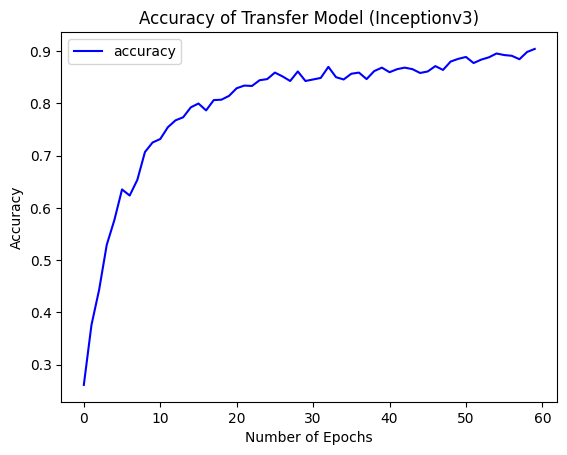

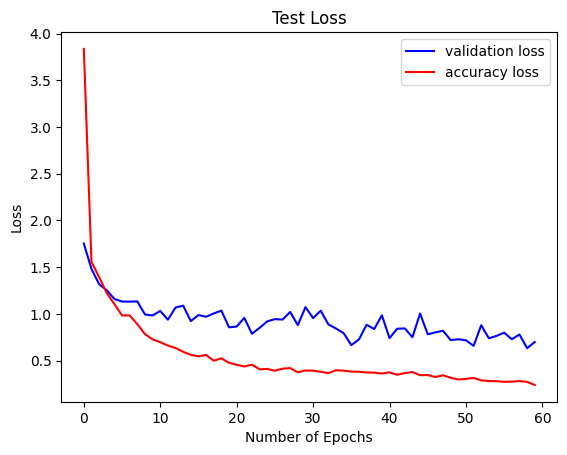

In [5]:
import matplotlib.pyplot as plt

# show the accuracy of method 2
plt.plot(history.history["accuracy"], color="b", label="accuracy")
plt.title("Accuracy of Transfer Model (Inceptionv3)")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# show the training (and validation) loss of method 2
plt.plot(history.history["val_loss"], color="b", label="validation loss")
plt.plot(history.history["loss"], color="r", label="accuracy loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [6]:
transfer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,264,564 (119.26 MB)

 Trainable params: 3,153,926 (12.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 6,307,854 (24.06 MB)

## Method 2: Vision Transformer

In [7]:
import keras_hub

EPOCHS = 10
PRESET = "vit_base_patch16_224_imagenet"

# vit_imageconverter = keras_hub.layers.ImageConverter.from_preset(PRESET)
vit_backbone = keras_hub.models.ViTBackbone(
    image_shape=(128, 128, 3),
    patch_size=16,
    num_layers=16,
    num_heads=16,
    hidden_dim=64,
    mlp_dim=1024,
    attention_dropout=0.1,
    dropout_rate=0.1,
)
vit_model = keras_hub.models.ViTImageClassifier(vit_backbone, num_classes=len(classes))

vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = vit_model.fit(train_ds_optimized, epochs=EPOCHS, validation_data=validation_ds_optimized)

Epoch 1/10
     11/Unknown 83s 5s/step - accuracy: 0.1713 - loss: 5.0762

/home/ubuntu/CS180-Project/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - accuracy: 0.1706 - loss: 5.0075 - val_accuracy: 0.0951 - val_loss: 2.1808
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1670 - loss: 3.4811

2025-05-19 22:11:48.995179: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.1660 - loss: 3.4203 - val_accuracy: 0.0951 - val_loss: 2.0087
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.1781 - loss: 1.8706 - val_accuracy: 0.0951 - val_loss: 1.8597
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.1781 - loss: 1.8125 - val_accuracy: 0.0951 - val_loss: 1.8214
Epoch 5/10
 8/11 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.1799 - loss: 1.7990

KeyboardInterrupt: 